### Rent Curve Estimation

This step focuses on estimating the relationship between land price and distance to the city center. The point with the highest observed land price is used as the city center. Distances from each land parcel to the center are computed, and a regression of land price on distance is performed to obtain the **rent curve**.

The procedure includes the following components:


1. **Rural Land Price Estimation**

   * Match rural land rent data with corresponding province-city (or municipality-county) to produce the file `agr_val_with_admin.csv`, and save city-specific results to the `/Agr_lp` folder.
   * Filter out data points located within built-up areas to focus on rural land only.
   * Compute the average present value of rural land prices for each city.

2. **Rent Curve Fitting**

   * Convert housing prices into land prices: based on the Cobb-Douglas production function, we estimate the share of land in production (denoted by $\alpha$), and then compute unit land price as

     $$
     \text{Land Price} = \alpha \times \text{Housing Price}
     $$
   * Perform an OLS regression of land price on distance to obtain the rent curve.

3. **Welfare Loss Estimation**

   * Compute the theoretical urban boundary (based on rural-urban land price equality).
   * Measure the gap between the actual and theoretical urban-rural boundaries.
   * Use this gap to calculate the triangular **welfare loss** caused by constrained urban expansion.



In [21]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import re
from shapely.ops import unary_union
import numpy as np

In [7]:
def parse_prov_city_from_filename(filename: str):
    """
    Parse province and city from filename.
    Example: 'Anhui-Anqing_hp.csv' → ('Anhui', 'Anqing')
    """
    base = os.path.basename(filename)
    if base.endswith('_hp.csv'):
        base = base[:-len('_hp.csv')]
    try:
        prov, city = base.split('-', 1)
        return prov.strip(), city.strip()
    except ValueError:
        raise ValueError(f"Failed to parse province and city from filename: {filename}")


## Average Rural Land Price

### Split Rural Land Rent Data and Match with Province, City, and County

I begin by processing the raw rural land rent dataset. This involves:

* Splitting the data by administrative regions (province, city, county);
* Matching each entry with its corresponding administrative unit;
* Ensuring consistent naming conventions and accurate alignment with shapefiles or statistical boundaries used in downstream analysis.

This step produces city- or county-level rural land price files, which serve as the basis for computing average rural land values in each region.


In [ ]:

agr_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/agr_val_2022.csv"
admin_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_Adm_2020/China2020County.shp"
output_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/agr_val_with_admin.csv"


df = pd.read_csv(agr_path)
gdf_agr = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")


gdf_admin = gpd.read_file(admin_path).to_crs("EPSG:4326")
gdf_admin = gdf_admin.rename(columns={
    "NAME_1": "province",
    "NAME_2": "city",
    "NAME_3": "county"
})
if not gdf_admin.is_valid.all():
    gdf_admin["geometry"] = gdf_admin.buffer(0)


gdf_joined = gpd.sjoin(
    gdf_agr,
    gdf_admin[["province", "city", "county", "geometry"]],
    how="left",
    predicate="intersects"
)


n_total = len(gdf_joined)
n_matched = gdf_joined["province"].notna().sum()
match_rate = n_matched / n_total * 100

print(f"successfully matched {n_matched} out of {n_total} points.")
print(f"match rate: {match_rate:.2f}%")


gdf_joined.drop(columns=["geometry", "index_right"], inplace=True)
gdf_joined = gdf_joined.dropna(subset=["province"])
gdf_joined.to_csv(output_path, index=False)


print(f"completed! The output file is saved at {output_path}.")


successfully matched 73003 out of 157267 points.
match rate: 46.42%
completed! The output file is saved at /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/agr_val_with_admin.csv.


In [ ]:
import pandas as pd
import os

agr_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/agr_val_with_admin.csv"
agr_output_dir = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/Agr_lp"
os.makedirs(agr_output_dir, exist_ok=True)

df = pd.read_csv(agr_path)

df["city"] = df["city"].replace(["NULL", "null", "", "NaN", "nan"], pd.NA)

def generate_prov_city(row):
    if pd.notna(row["city"]):
        return f"{row['province']}-{row['city']}"
    elif pd.notna(row["county"]):
        return f"{row['province']}-{row['county']}"
    else:
        return pd.NA

df["prov_city"] = df.apply(generate_prov_city, axis=1)


for prov_city, group in df.groupby("prov_city"):
    if pd.isna(prov_city):
        continue

    filename = f"{prov_city.strip().replace(' ', '_')}_agr_lp.csv"
    output_path = os.path.join(agr_output_dir, filename)

    group.to_csv(output_path, index=False)
    print(f"saved {len(group)} points to {output_path}")

print("completed!")



In [81]:
df.head()

,lon,lat,value,area_m2,price_tal_are,price_m2,province,city,county,prov_city
0,110.625000,42.458333,113.744060,6.348930e+07,1533700.4,0.024157,Neimenggu,Baotou,Daerhanmaominganlianhe,Neimenggu-Baotou
1,109.625000,42.208333,283.251280,6.374217e+07,3819299.2,0.059918,Neimenggu,Baotou,Daerhanmaominganlianhe,Neimenggu-Baotou
2,110.125000,42.208333,137.060730,6.374217e+07,1848097.5,0.028993,Neimenggu,Baotou,Daerhanmaominganlianhe,Neimenggu-Baotou
3,110.041667,42.125000,46.350080,6.382619e+07,624974.5,0.009792,Neimenggu,Baotou,Daerhanmaominganlianhe,Neimenggu-Baotou
4,109.541667,42.041667,74.622765,6.391007e+07,1006197.4,0.015744,Neimenggu,Baotou,Daerhanmaominganlianhe,Neimenggu-Baotou


### Filter Points Outside Built-Up Areas

We retain only the rural land points located **outside the built-up area**, as these better represent agricultural land use. This involves:

* Performing a spatial join between rural land points and the built-up area shapefile;
* Filtering out all points that fall **within** built-up boundaries;
* Verifying the number of remaining valid points per city to ensure sufficient data coverage for estimating rural land prices.


In [ ]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

input_dir = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/Agr_lp"
builtup_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp"


gdf_builtup = gpd.read_file(builtup_path).to_crs("EPSG:4326")
if not gdf_builtup.is_valid.all():
    gdf_builtup["geometry"] = gdf_builtup.buffer(0)

zero_remaining_files = 0
total_files = 0
zero_file_list = []


for filename in os.listdir(input_dir):
    if not filename.endswith(".csv"):
        continue

    total_files += 1
    file_path = os.path.join(input_dir, filename)

    df = pd.read_csv(file_path)
    if df.empty or "lon" not in df.columns or "lat" not in df.columns:
        print(f"Warning: File {filename} is missing required fields or is empty. Skipping.")
        continue

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
    gdf_filtered = gpd.sjoin(gdf, gdf_builtup, predicate="within", how="left")
    gdf_remaining = gdf_filtered[gdf_filtered["index_right"].isna()]  

    if len(gdf_remaining) == 0:
        zero_remaining_files += 1
        zero_file_list.append(filename)

zero_ratio = zero_remaining_files / total_files * 100 if total_files > 0 else 0
print(f"\nTotal number of files: {total_files}")
print(f"Number of files with 0 remaining points: {zero_remaining_files}")
print(f"Proportion: {zero_ratio:.2f}%")

if zero_file_list:
    print("\nList of files with 0 remaining points:")
    for fname in zero_file_list:
        print(f"- {fname}")


/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



Total number of files: 440
Number of files with 0 remaining points: 9
Proportion: 2.05%

List of files with 0 remaining points:
- Shanghai-Yangpu_agr_lp.csv
- Shanghai-Putuo_agr_lp.csv
- Beijing-Shijingshan_agr_lp.csv
- Shanghai-Changning_agr_lp.csv
- Shanghai-Huangpu_agr_lp.csv
- Shanghai-Hongkou_agr_lp.csv
- Chongqing-Dadukou_agr_lp.csv
- Shanghai-Minhang_agr_lp.csv
- Tianjin-Nankai_agr_lp.csv


### Estimating Average Agricultural Land Price

In highly urbanized cities—such as Beijing and Shanghai—some districts have very limited rural land area, resulting in a small number of usable rural land observations. For cities or counties with **fewer than 5 rural land data points**, we skip the built-up area filtering step and directly compute the average land price using all available points.

The **present value** of rural land is calculated under the standard land valuation framework, treating land as a perpetual income-generating asset:

$$
P = \frac{R}{r}
$$

where:

* $P$ is the land price,
* $R$ is the annual rural land rent (in RMB/m²/year),
* $r = 0.05$ is the assumed discount rate, reflecting opportunity cost, depreciation, and risk.

The processed city-level average land price results are saved in the file `avg_lp.csv`.


In [ ]:
avg_output_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/avg_lp.csv"

gdf_builtup = gpd.read_file(builtup_path).to_crs("EPSG:4326")
if not gdf_builtup.is_valid.all():
    gdf_builtup["geometry"] = gdf_builtup.buffer(0)

results = []

for filename in os.listdir(input_dir):
    if not filename.endswith(".csv"):
        continue

    file_path = os.path.join(input_dir, filename)
    df = pd.read_csv(file_path)

    if df.empty or "lon" not in df.columns or "lat" not in df.columns or "price_m2" not in df.columns:
        continue

    prov_city = filename.replace("_agr_lp.csv", "")
    try:
        prov, city = prov_city.split("-", 1)
    except ValueError:
        print(f"Warning: Failed to parse province and city from filename: {filename}")
        continue

    if len(df) <= 5:
        avg_price = df["price_m2"].mean() / 0.05
        results.append({
            "prov": prov,
            "city": city,
            "prov_city": prov_city,
            "land_price": avg_price
        })
        continue

    # filter points within and without built-up areas
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
    gdf_filtered = gpd.sjoin(gdf, gdf_builtup, predicate="within", how="left")
    gdf_outside = gdf_filtered[gdf_filtered["index_right"].isna()]

    if gdf_outside.empty:
        continue
    else:
        avg_price = gdf_outside["price_m2"].mean() / 0.05
        results.append({
            "prov": prov,
            "city": city,
            "prov_city": prov_city,
            "land_price": avg_price
        })

df_result = pd.DataFrame(results)
df_result.to_csv(avg_output_path, index=False)
print(f"Saved average land price estimates to: {avg_output_path}")



/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Saved average land price estimates to: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/avg_lp.csv


## OLS fitting rent curve

### Land Output Elasticity and Land Price Estimation

We assume a Cobb-Douglas production function:

$$
Y = A \cdot L^{\alpha} \cdot K^{\beta} \cdot N^{\gamma}
$$


Assuming land is a capitalized asset, its price equals to its marginal product:

$$
P_L = \alpha \cdot \frac{Y}{L}
$$

If housing price approximates per-unit output value, we estimate land price as:

$$
P_L = \alpha \cdot P_{\text{house}}
$$

We set $\alpha = 0.3$, based on Zhang and Jin (2012), who estimate the land elasticity from a translog production function and find $\alpha \approx 0.293$. Due to limited data for city-level estimation, we adopt this unified value throughout the analysis.


In [ ]:
alpha = 0.3

In [86]:
df = pd.read_csv("/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/City_hp/Anhui-Anqing_hp.csv")
df.head()

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,...,类型.1,供水,得分,月份,环比,价格,province,city,county,prov_city
0,4677,德宽路281-106号小区,安庆,大观,安庆八佰伴,2000,多层,德宽路281-106号,117.028524,30.515266,...,公寓住宅,民用,7.4,12,0.0,8000.0,Anhui,Anqing,Daguan,Anhui-Anqing
1,4674,市府路87号小区,安庆,大观,安庆八佰伴,2000,多层,市府路87号,117.044715,30.526213,...,公寓住宅,民用,7.9,12,0.0,6000.0,Anhui,Anqing,Daguan,Anhui-Anqing
2,4703,广播局宿舍,安庆,大观,安庆八佰伴,1998,多层,"集贤路,近菱湖南路",117.037857,30.518130,...,公寓住宅,民用,7.9,12,0.0,7600.0,Anhui,Anqing,Daguan,Anhui-Anqing
3,4702,玉琳路6号区,安庆,大观,安庆八佰伴,2000,多层,"玉琳路,近程良路",117.027374,30.506336,...,公寓住宅,民用,7.3,12,0.0,15919.0,Anhui,Anqing,Daguan,Anhui-Anqing
4,4701,电信局宿舍,安庆,大观,安庆八佰伴,1998,多层,孝肃路190号,117.035686,30.513105,...,公寓住宅,民用,7.2,12,0.0,8000.0,Anhui,Anqing,Daguan,Anhui-Anqing


In [5]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import statsmodels.api as sm
import os

def fit_urban_land_rent_curve(prov, city, alpha=0.3,
                               base_dir="/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/City_hp"):
    """
    Given a city and alpha, estimate urban land rent curve:
    1. Load city CSV
    2. Compute land_price = alpha * house_price
    3. Identify city center (highest land_price)
    4. Compute distances from each point to center
    5. Fit land_price ~ dist

    Returns: (fitted OLS model, processed DataFrame)
    """

    filename = f"{prov}-{city}_hp.csv"
    file_path = os.path.join(base_dir, filename)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None, None


    df = pd.read_csv(file_path)
    if "价格" not in df.columns or "lng84" not in df.columns or "lat84" not in df.columns:
        print(f"Missing required columns in: {filename}")
        return None, None

 
    df = df.rename(columns={"价格": "house_price"})
    df["land_price"] = df["house_price"] * alpha


    max_idx = df["land_price"].idxmax()
    center_coord = (df.loc[max_idx, "lat84"], df.loc[max_idx, "lng84"])

    def calc_dist(row):
        return geodesic((row["lat84"], row["lng84"]), center_coord).km

    df["dist"] = df.apply(calc_dist, axis=1)
    df = df.dropna(subset=["land_price", "dist"])


    X = sm.add_constant(df["dist"])
    y = df["land_price"]
    model = sm.OLS(y, X).fit()

    return center_coord,model, df


In [6]:
(center_lat, center_lon), model, df_result = fit_urban_land_rent_curve("Sichuan","Chengdu", alpha=0.3)
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             land_price   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     3917.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        16:26:46   Log-Likelihood:            -1.4874e+05
No. Observations:               16490   AIC:                         2.975e+05
Df Residuals:                   16488   BIC:                         2.975e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5958.3066     34.366    173.377      0.000    5890.945    6025.668
dist         -70.7437      1.130    -62.583      0.000     -72.959     -68.528
==============================================================================
Omnibus:                     9763.547   Durbin-Watson:                   1.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147363.237
Skew:                           2.568   Prob(JB):                         0.00
Kurtosis:                      16.715   Cond. No.                         67.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Welfare Loss Calculation Function – OLS

### Computing the Theoretical Urban Boundary

Given the `prov`, `city`, and the estimated rent-distance curve (from the OLS model), we proceed as follows:

* First, retrieve the corresponding **rural land price** from `avg_lp.csv` for the specified city.
* If a city-level match is not available, fall back to the **provincial average** rural land price.

Using the fitted rent curve, we then calculate the **theoretical urban boundary**, defined as the distance from the city center where the urban land rent equals the rural land price. This is the point at which it becomes unprofitable for the city to expand further under market-based land allocation.


In [7]:
import pandas as pd

def get_urban_rural_boundary_edge(prov, city, model,
                                   avg_lp_path="/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/avg_lp.csv"):
    """
    Given province and city, and a land rent regression model (land_price ~ dist),
    return the implied urban edge (distance where land_price equals rural land_price).

    Returns:
        float (edge in km) or None if not found
    """

    key = f"{prov}-{city}"
    df_lp = pd.read_csv(avg_lp_path)
    df_lp = df_lp.dropna(subset=["prov_city", "land_price"])

    match = df_lp[df_lp["prov_city"] == key]
    if not match.empty:
        rural_lp = match["land_price"].values[0]
    else:
        prov_matches = df_lp[df_lp["prov"] == prov]
        if not prov_matches.empty:
            rural_lp = prov_matches["land_price"].mean()
            print(f"Using provincial average land price for {prov}: {rural_lp:.4f}")
        else:
            print(f"No land price data available for {key} or {prov}")
            return None

    beta0 = model.params["const"]
    beta1 = model.params["dist"]

    if beta1 == 0:
        print("Warning: distance coefficient is zero.")
        return None

    edge = (rural_lp - beta0) / beta1
    return edge if edge > 0 else None


In [8]:

edge_km = get_urban_rural_boundary_edge("Sichuan","Chengdu", model)
print(f"Estimated urban edge distance (km): {edge_km:.2f}" if edge_km else "No valid edge found")


Estimated urban edge distance (km): 83.58


### Comparison of Actual and Theoretical Urban Area

Using the location with the highest housing price as the city center (i.e., the circle’s center), we draw a circle with a radius equal to the theoretical urban-rural boundary. This visualizes and compares the actual built-up area with the idealized circular urban footprint under the theoretical model.


In [16]:


def find_shp_file(prov, city, root_path="/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020"):

    prov_folder = os.path.join(root_path, prov)
    if not os.path.isdir(prov_folder):
        print(f"Warning: Province folder does not exist: {prov_folder}")
        return None

    shp_files = [f for f in os.listdir(prov_folder) if f.endswith(".shp")]
    city_lower = city.lower()
    prov_lower = prov.lower()

    matched_file = None

    for f in shp_files:
        if city_lower in f.lower():
            matched_file = os.path.join(prov_folder, f)
            break
    if not matched_file:
        for f in shp_files:
            if prov_lower in f.lower():
                matched_file = os.path.join(prov_folder, f)
                break

    return matched_file

def analyze_builtup_vs_theory_edge(prov, city, center_lon, center_lat, radius_km,
                                    root_path="/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020"):


    matched_file = find_shp_file(prov, city, root_path)
    if not matched_file:
        print(f"Error: No matching shapefile found for {prov}-{city}.")
        return

    gdf_built = gpd.read_file(matched_file).to_crs("EPSG:3857")
    gdf_built["geometry"] = gdf_built["geometry"].buffer(0)
    gdf_built = gdf_built[gdf_built.is_valid]  

    center_proj = gpd.GeoSeries([Point(center_lon, center_lat)], crs="EPSG:4326").to_crs("EPSG:3857").iloc[0]
    circle_geom = center_proj.buffer(radius_km * 1000)  

    gdf_circle = gpd.GeoDataFrame(geometry=[circle_geom], crs="EPSG:3857")
    intersection = gdf_built.intersects(circle_geom)

    gdf_circle = gpd.GeoDataFrame(geometry=[circle_geom], crs="EPSG:3857")
    intersection = gdf_built.intersects(circle_geom)

    ax = gdf_built.plot(edgecolor='black', facecolor='none', linewidth=0.5)
    gdf_circle.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
    plt.title(f"Built-up vs Theoretical Edge for {city}, {prov}")
    plt.show()

    overlap_ratio = intersection.sum() / len(gdf_built)
    print(f"Overlap ratio of built-up area within {radius_km} km of center: {overlap_ratio:.2f}")


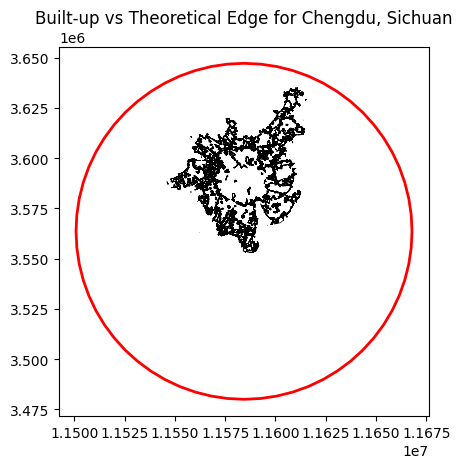

Overlap ratio of built-up area within 83.5811910302458 km of center: 1.00


In [17]:
analyze_builtup_vs_theory_edge("Sichuan","Chengdu", center_lon, center_lat, edge_km)


### Measuring the Distance Between Actual and Theoretical Urban-Rural Boundaries

Due to the highly irregular shape of urban edges, it is difficult to directly measure the overall distance between the actual and theoretical urban-rural boundaries. To address this, my algorithm constructs a theoretical boundary as a circle centered on the city center with a given radius. It then samples 300 points along the **actual built-up boundary** that lie within this theoretical boundary. The average distance between these sampled points and the theoretical boundary is computed and used as a summary measure of the **gap between actual and theoretical urban-rural boundaries**.


In [ ]:

def mean_internal_radius_gap_op(prov, city, center, R,
    root_path="/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020",
    crs_metric="EPSG:3857", sample_count=300, simplify_tolerance=5.0):
    """
    Compute the average internal radius gap: the average of (R - d),
    where d is the distance from each sampled built-up area boundary point
    (within radius R) to the city center.

    Args:
        prov, city         : Province and city name, used to locate the shapefile.
        center             : City center coordinates (lon, lat).
        R                  : Theoretical urban-rural boundary radius (in meters).
        root_path          : Root directory containing provincial shapefiles.
        crs_metric         : Projected CRS for distance calculations (default: EPSG:3857).
        sample_count       : Total number of points to sample along all outer boundaries.
        simplify_tolerance : Tolerance for simplifying the polygon boundaries (in meters) to speed up sampling.

    Returns:
        Mean internal gap (in kilometers); returns 0.0 if no valid points found.
    """

    shp_path = find_shp_file(prov, city, root_path)
    if shp_path is None:
        raise FileNotFoundError(f"Shapefile not found: prov={prov}, city={city}")

    gdf = gpd.read_file(shp_path).to_crs(crs_metric)
    builtup_union = gdf.unary_union
    
    Origin = gpd.GeoSeries([Point(center)], crs="EPSG:4326").to_crs(crs_metric).iloc[0]

    if builtup_union.geom_type == "Polygon":
        exteriors = [builtup_union.exterior.simplify(simplify_tolerance)]
    else:
        exteriors = [poly.exterior.simplify(simplify_tolerance) for poly in builtup_union.geoms]

    lengths = [ext.length for ext in exteriors]
    total_length = sum(lengths)
    if total_length == 0:
        return 0.0

    all_pts = []
    for ext, L in zip(exteriors, lengths):
        n = max(int(sample_count * (L / total_length)), 1)
        dists = np.linspace(0, L, n, endpoint=False)
        all_pts.extend([ext.interpolate(d) for d in dists])

    gaps = []
    for pt in all_pts:
        d = pt.distance(Origin)
        if d <= R:
            gaps.append(R - d)

    return float(np.mean(gaps)) / 1000 if gaps else 0.0


In [20]:


gap_km = mean_internal_radius_gap_op(
    "Sichuan","Chengdu",
    center=(center_lon, center_lat),
    R=edge_km * 1000,
    root_path= "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020",
)
print(f"Mean internal radius gap for {prov}-{city}: {gap_km:.2f} km")


/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/ipykernel_46914/3692902767.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  builtup_union = gdf.unary_union


Mean internal radius gap for Beijing-Xicheng: 46.19 km


### Welfare Loss Calculation Function – OLS

Given the distance between the actual and theoretical urban-rural boundaries and an estimated OLS rent-distance function, this function computes:

* the **welfare loss** as the area of a triangle between the two boundaries, and
* the **welfare loss as a proportion** of the total theoretical land rent under full expansion.


In [37]:
def compute_welfare_loss_triangle_linear(model, edge_km, gap_km):
    """
    Compute the welfare loss as the area of a triangle under a linear rent curve:
      r(d) = beta_0 + beta_1 * d

    Args:
      model    : Fitted statsmodels OLS result (regression of price on distance)
      edge_km  : Theoretical urban boundary radius (in kilometers)
      gap_km   : Average distance between theoretical and actual urban boundary (in kilometers)

    Returns:
      loss     : Welfare loss triangle area (in price * km units)
    """
    dist_a = edge_km - gap_km
    if dist_a <= 0:
        return 0.0

    slope_name = [n for n in model.params.index if n != "const"][0]
    beta1 = model.params[slope_name]

    loss = -0.5 * beta1 * gap_km**2

    S = 0.5 * edge_km * (- beta1 * edge_km)

    loss_ratio = loss / S if S != 0 else 0.0

    return loss,loss_ratio


In [38]:
loss,loss_ratio = compute_welfare_loss_triangle_linear(model, edge_km, gap_km)
print(f"Welfare loss triangle area: {loss:.2f}")
print(f"Welfare loss ratio: {loss_ratio:.2%}")

Welfare loss triangle area: 75459.65
Welfare loss ratio: 30.54%
